# Introduction

This notebook presents couple examples of **graph visualization** in **pytorch**.

**NOTE**: graph vizualization code was originally copied from https://github.com/szagoruyko/pytorchviz. Subsequenty modified by me.

Contents:
* [Imports](#Imports)
* [Graph Vizualization](#Graph-Vizualization)
* [Simple Operations Test](#Simple-Operations-Test)
* [Simple Model Test](#Simple-Model-Test)
* [U-Net Test](#U-Net-Test)
* [ResNet18 Test](#ResNet18-Test)

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Pick GPU if available

In [3]:
device = 'cpu' # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Graph Vizualization

Functions in this section are copy-pasted from [https://github.com/szagoruyko/pytorchviz](https://github.com/szagoruyko/pytorchviz)

In [4]:
from graphviz import Digraph

In [5]:
class GradFnHook():
    def __init__(self, grad_fn):
        self.iter = 0
        self.grad_fn = grad_fn
    def __call__(self, inputs, outputs):
        self.iter += 1
        self.inputs = inputs
        self.outputs = outputs

In [6]:
def add_hooks(*output_tensors):
    def add_nodes(var):
        if var not in seen:
            
            bh = GradFnHook(var)
            var.register_hook(bh)
            
            hooks[var] = bh
            seen.add(var)
            
            #if hasattr(var, 'next_functions'):
            for u in var.next_functions:
                if u[0] is not None:
                    add_nodes(u[0])

    # convert to nodes
    nodes = tuple(ot.grad_fn for ot in output_tensors)
    
    hooks = {}
    seen = set()
    
    for grad_fn in nodes:
        add_nodes(grad_fn)
        
    return hooks

In [7]:
def size_to_str(size):
    if len(size) == 0:
        return '(scalar)'
    return '(' + (', ').join(['%d' % v for v in size]) + ')'

In [8]:
def var_to_str(var):
    def rchop(string, endings):
        for ending in endings:
            if string.endswith(ending):
                return string[:-len(ending)]
        return string
    return rchop(type(var).__name__, ['Backward', 'Backward0', 'Backward1', 'Backward2', 'Backward3'])

In [9]:
class DummyGradFn():
    def __init__(self, tensor):
        self.variable = tensor
        self.next_functions = [[tensor.grad_fn, 0]]

In [10]:
def make_dot(outputs, inputs=None, params=None, hooks=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """

    def add_nodes(var):
        if var not in seen:
            if hasattr(var, 'variable'):
                tensor = var.variable
                
                if id(tensor) in output_map:
                    name = output_map[id(tensor)]
                    color = 'darkolivegreen1'
                elif id(tensor) in param_map:
                    name = param_map[id(tensor)]
                    color = 'orange'
                elif id(tensor) in input_map:
                    name = input_map[id(tensor)]
                    color = 'lightblue'
                else:
                    name = ''
                    color = 'lightgray'
            
                node_name = str.format('{}\n{}', name, size_to_str(tensor.size()))
                dot.node(str(id(var)), node_name, fillcolor=color, style='filled', shape='box')
            
            else:
                
                if hooks is not None and var in hooks:
                    output_tensors = hooks[var].outputs
                    node_name = var_to_str(var)
                    for tensor in output_tensors:
                        node_name += '\n' + size_to_str(tensor.size())
                    
                else:
                    node_name = var_to_str(var)
                
                dot.node(str(id(var)), node_name, fillcolor='lightgray')
            
            seen.add(var)
            
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        label = None
#                         if hooks is not None and var in hooks and u[0] in hooks:
#                             inp_tup = hooks[var].inputs  # tensor
#                             out_tup = hooks[u[0]].outputs
#                             inters = set(inp_tup).intersection(set(out_tup))
#                             if len(inters) == 1:  # if multiple paths through graph then this will fail
#                                 tensor = inters.pop()
#                                 label = size_to_str(tensor.size())
                        
                        dot.edge(str(id(u[0])), str(id(var)), label=label)
                        add_nodes(u[0])

    assert all(isinstance(o, torch.Tensor) for o in outputs.values())
    output_map = {id(tensor): string for string, tensor in outputs.items()}
        
    if inputs is not None:
        assert all(isinstance(i, torch.Tensor) for i in inputs.values())
        input_map = {id(tensor): string for string, tensor in inputs.items()}
    else:
        input_map = {}
        
    if params is not None:
        assert all(isinstance(p, torch.Tensor) for p in params.values())
        param_map = {id(tensor): string for string, tensor in params.items()}
    else:
        param_map = {}

    node_attr = dict(style='rounded,filled', shape='box', align='top', fontsize='12', ranksep='0.1', height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="10,1000"))

    seen = set()

    output_nodes = [DummyGradFn(tensor) for _, tensor in outputs.items()]
            
            
    for grad_fn in output_nodes:
        add_nodes(grad_fn)


    return dot

# Simple Operations Test

Test single output

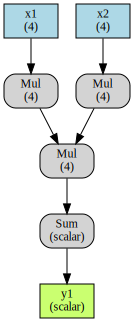

In [11]:
# define inputs
x1 = torch.tensor([0., 1, 2, 3], requires_grad=True)
x2 = torch.tensor([2., 3, 4, 5], requires_grad=True)

# perform computation
h1 = 2 * x1
h2 = 2 * x2
h3 = h1 * h2
y1 = torch.sum(h3)

# gather shape information (optional)
hooks = add_hooks(y1)
y1.backward()

# visualize
make_dot(outputs={'y1':y1}, inputs={'x1':x1, 'x2':x2}, hooks=hooks)

Test multiple outputs

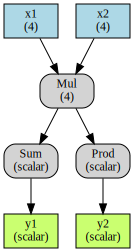

In [12]:
# define inputs
x1 = torch.tensor([0., 1, 2, 3], requires_grad=True)
x2 = torch.tensor([2., 3, 4, 5], requires_grad=True)

# perform computation
h1 = x1 * x2
y1 = torch.sum(h1)
y2 = torch.prod(h1)

# gather shape info (optional)
hooks = add_hooks(y1, y2)
y1.backward(retain_graph=True)
y2.backward()

# visualize
make_dot(outputs={'y1':y1, 'y2':y2}, inputs={'x1':x1, 'x2':x2}, hooks=hooks)

# Simple Model Test

In [18]:
from collections import OrderedDict
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)),
            ('elu', nn.ELU()),
            ('pool', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ]))
        
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)),
            ('elu', nn.ELU()),
            ('pool', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ]))
        
        self.layer3 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('elu', nn.ELU()),
            ('pool', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ]))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('drop1', nn.Dropout(0.2)),
            ('fc1', nn.Linear(in_features=1024, out_features=512)),
            ('drop2', nn.Dropout(0.2)),
            ('fc2', nn.Linear(in_features=512, out_features=10)),
        ]))
        
        
    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        
        x = self.layer1(x)
        
        x = self.maxpool(F.elu(self.conv2(x)))
        x = self.maxpool(F.elu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.elu(self.lin1(x))
        x = self.drop(x)
        x = self.lin2(x)  # no activation after last linear
        return x

model = Net()
#model.to(device)
criterion = nn.CrossEntropyLoss()                 # softmax included in here
optimizer = torch.optim.Adam(model.parameters())

Simple print

In [22]:
print(model)

Net(
  (layer1): Sequential(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (drop1): Dropout(p=0.2)
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (drop2): Dropout(p=0.2)
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Print using torchsummary

In [26]:
try:
    from torchsummary import summary
    summary(model, input_size=(3, 32, 32), device=device)
except ImportError:
    print('torchsummary module not available, skipping')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
               ELU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
               ELU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
               ELU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
          Dropout-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 553,514
Trainable params:

Visualize using original torchviz

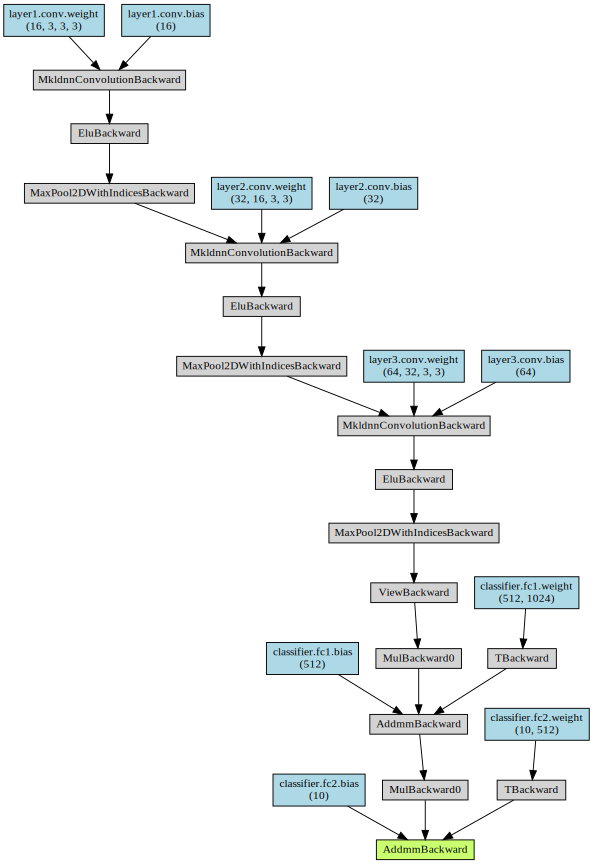

In [33]:
dot = None
try:
    import torchviz
    
    # define inputs
    x = torch.randn(10, 3, 32, 32, device=device)

    # perform computation
    o = model(x)

    # visualize
    dot = torchviz.make_dot(o, params=dict(model.named_parameters()))

except ImportError:
    print('torchviz module not available, skipping')
dot

Visualize using this notebook

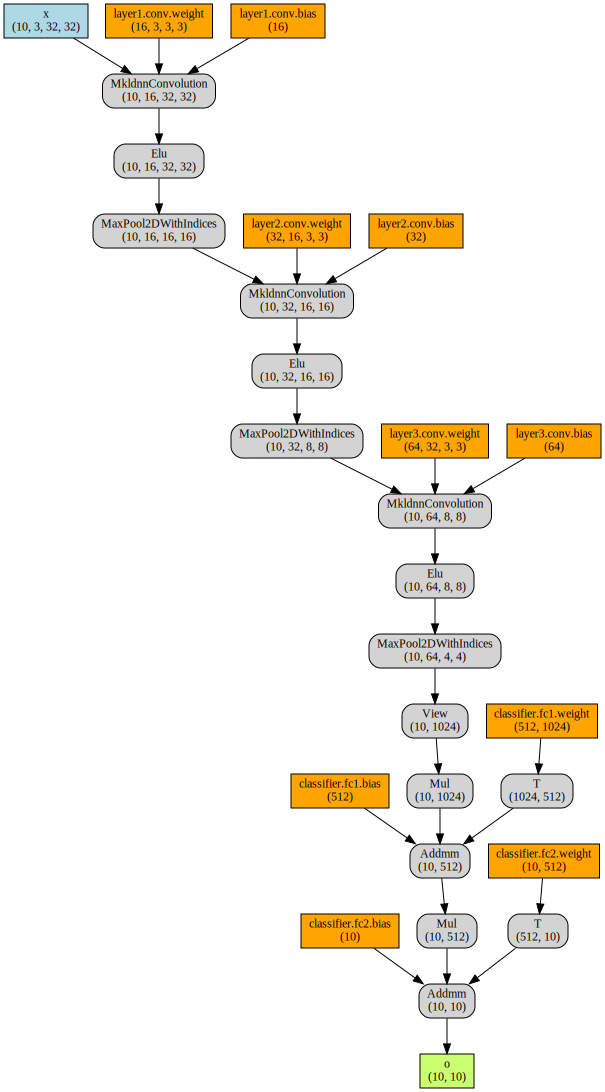

In [34]:
# define inputs
x = torch.randn(10, 3, 32, 32, device=device, requires_grad=True)

# perform computation
o = model(x)

# gather shape info (optional)
hooks = add_hooks(o)
o.backward(torch.ones_like(o))

# visualize
make_dot(outputs={'o': o}, inputs={'x': x}, params=dict(model.named_parameters()), hooks=hooks)

# U-Net Test

In [35]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dconv_down2 = double_conv(64, 128)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dconv_down3 = double_conv(128, 256)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dconv_down4 = double_conv(256, 512)        
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool1(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool2(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool3(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return x # out

model = UNet(n_class=6)
model.to(device);

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


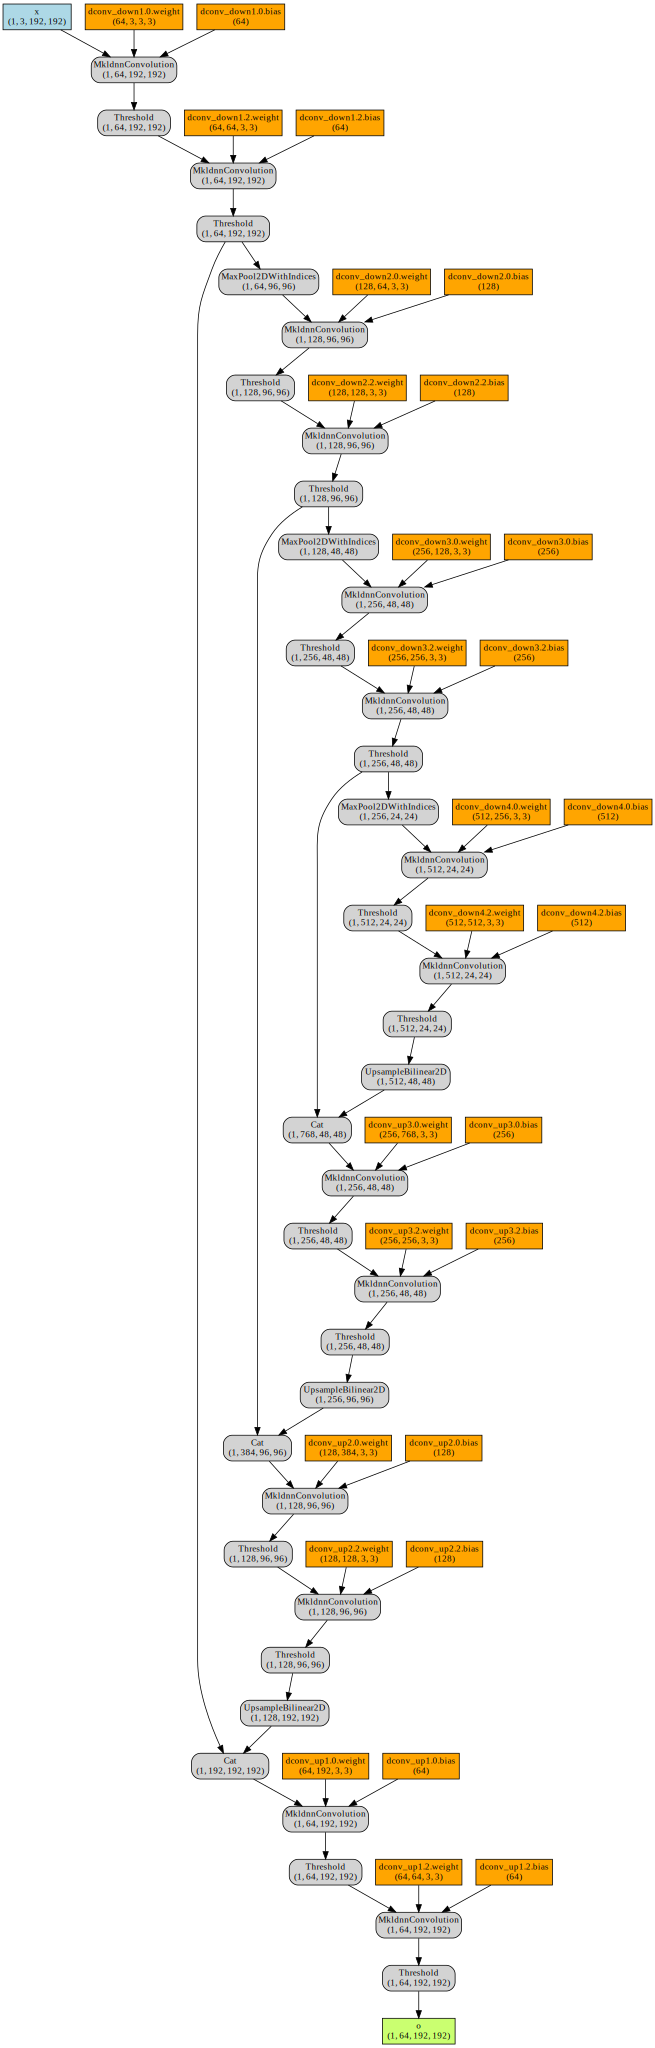

In [36]:
x = torch.randn(1, 3, 192, 192, device=device, requires_grad=True)
params = dict(model.named_parameters())
o = model(x)

hooks = add_hooks(o)
o.backward(torch.ones_like(o))
make_dot(outputs={'o': o}, inputs={'x': x}, params=params, hooks=hooks)

In [39]:
print(model)
summary(model, input_size=(3, 192, 192), device=device)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv_down4): Sequential(
    (

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           1,792
              ReLU-2         [-1, 64, 192, 192]               0
            Conv2d-3         [-1, 64, 192, 192]          36,928
              ReLU-4         [-1, 64, 192, 192]               0
         MaxPool2d-5           [-1, 64, 96, 96]               0
            Conv2d-6          [-1, 128, 96, 96]          73,856
              ReLU-7          [-1, 128, 96, 96]               0
            Conv2d-8          [-1, 128, 96, 96]         147,584
              ReLU-9          [-1, 128, 96, 96]               0
        MaxPool2d-10          [-1, 128, 48, 48]               0
           Conv2d-11          [-1, 256, 48, 48]         295,168
             ReLU-12          [-1, 256, 48, 48]               0
           Conv2d-13          [-1, 256, 48, 48]         590,080
             ReLU-14          [-1, 256,

# ResNet18 Test

In [ ]:
import torchvision

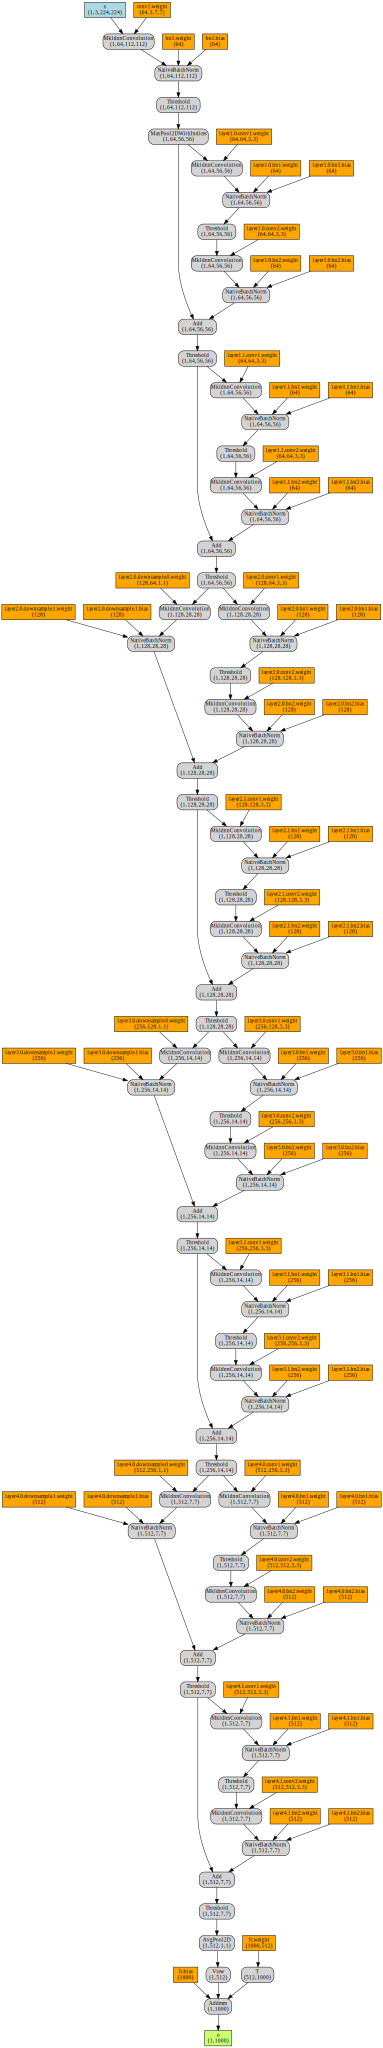

In [15]:
# define model
model = torchvision.models.resnet18().to(device)

# define inputs
x = torch.randn(1, 3, 224, 224, device=device, requires_grad=True)

# perform computation
o = model(x)

# gather shape info (optional)
hooks = add_hooks(o)
o.backward(torch.ones_like(o))

# visualize
make_dot(outputs={'o': o}, inputs={'x': x}, params=dict(model.named_parameters()), hooks=hooks)

# Old Code

In [ ]:
# def hook(module, input, output):
#     class_name = str(module.__class__).split(".")[-1].split("'")[0]
#     print('NAME:', module_to_string[module], class_name)
#     print('  inputs: ', end='')
#     for inp in input:
#         print(list(inp.shape), end=' ')
#     print()
#     #pdb.set_trace()
#     pass

In [ ]:
# def register_hook(module):
#     if (not isinstance(module, nn.Sequential)
#         and not isinstance(module, nn.ModuleList)
#         and not (module == model)):
#         hooks.append(module.register_forward_hook(hook))

In [ ]:
# for h in hooks:
#     h.remove()
# hooks = []
# model.apply(register_hook)